<a href="https://colab.research.google.com/github/alexdoyle115/Machine_learning_estimation_of_grass_herbage_mass_using_UAV_data/blob/main/model_training_%26_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estimateing herbage mass using UAV images 


###Table of Contents  

0.0   Setup

1.0   Image Preprocessing  

2.0   Small Convoltional Neural Network  

3.0   EfficientNet Model  

4.0   Visualizing Layers

5.0   Predictions 

6.0   Vegitation Indices

7.0   Saving Results 



### 0.0 Setup 

In [ ]:
# Connecting the notebook to google drive where the files are stored
from google.colab import drive 

drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# not a standard package in Google Colab
!pip install tensorflow-addons

In [ ]:
# Useful to collect results at the end
!pip install xlsxwriter 

In [ ]:
# Libraries
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np
import xlsxwriter
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

The noisy weights are required to be downloaded when run first. 

In [ ]:
#The efficientnet pretrained weights require the weights to be downloaded
##!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
##!tar -xf noisy_student_efficientnet-b0.tar.gz

In [ ]:
##!wget -q https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
##!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
##       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5

In [ ]:
# mounting the correct directory 
os.chdir("/gdrive/MyDrive/Grass/allimages/")

### 1.0 Image Preprocessing 

In [ ]:
# read in the excel sheet containing the labels as well as image numbers and then this can be used to loacte the images 
df = pd.read_excel("measures.xlsx")
df["image_location"] = (
      "./images/" + df["image_name"].astype(str) + ".png" )

In [ ]:
# Useful for experimenting with the number of images ran through the model
df = df.iloc[0:601]
batch_size = 64
cnn_lr = 0.001
ef_net_lr = 0.5

In [ ]:
# dividing the data frame into the subsets 
train, val = train_test_split(df, test_size=0.2, random_state=1)
train, test = train_test_split(train, test_size=0.125, random_state=1) 

print("total number of training images and dimensions: ", train.shape)  # type: ignore
print("total number of validation images and dimensions:  ", val.shape)  # type: ignore
print("total number of testing images and dimensions: ", test.shape)  # type: ignore

total number of training images and dimensions:  (420, 3)
total number of validation images and dimensions:   (121, 3)
total number of testing images and dimensions:  (60, 3)


In [ ]:
 # All images will be rescaled by 1./255. 
 # Augmentation carried out on the training data to maximise the small dataset
train_datagen = ImageDataGenerator(rescale=1.0 / 255,   # final image size of 255 * 255
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2,)


train_generator = train_datagen.flow_from_dataframe(
        # This is the target directory
        dataframe=train,
        x_col="image_location",  # locates folder where images are stored
        y_col="label",
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need classification labels
        class_mode='raw')

# Rescaling the validation images  
validation_generator = ImageDataGenerator(rescale=1./255)

validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val,
        x_col="image_location",
        y_col="label",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=batch_size,
    )

# Rescaling the test images 
test_generator = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_generator.flow_from_dataframe(
        dataframe=test,
        x_col="image_location",
        y_col="label",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=10,
    )

Found 420 validated image filenames.
Found 121 validated image filenames.
Found 60 validated image filenames.


### 2.0 Small Convolutional Neural Network 




In [ ]:
 # small_cnn
 
 
 model = models.Sequential()
 model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Conv2D(64, (3, 3), activation="relu"))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Conv2D(64, (3, 3), activation="relu"))

 model.add(layers.Flatten())
 model.add(layers.Dense(64, activation="relu"))
 model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [ ]:
# absolute mean error optimizer 

radam1 = tfa.optimizers.RectifiedAdam(learning_rate=cnn_lr)
ranger1 = tfa.optimizers.Lookahead(radam1, sync_period=6, slow_step_size=0.5)
optimizer1 = ranger1

In [ ]:
# root mean square error optimizer 
#opt = tf.keras.optimizers.RMSprop(learning_rate=cnn_lr)


In [ ]:
# compiling the model

model.compile(optimizer=optimizer1, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )

In [ ]:
# saving the model history

history_small_cnn = model.fit( train_generator, 
                     epochs = 25,
                     steps_per_epoch = 2,
                     validation_data=validation_generator,
                     workers = 6,)

Epoch 1/25
2/2 [==============================] - 61s 38s/step - loss: 86.3972 - mean_absolute_error: 86.6872 - mean_absolute_percentage_error: 104.0446 - val_loss: 86.7016 - val_mean_absolute_error: 86.5791 - val_mean_absolute_percentage_error: 104.5992
Epoch 2/25
2/2 [==============================] - 36s 13s/step - loss: 88.2985 - mean_absolute_error: 88.2985 - mean_absolute_percentage_error: 103.2834 - val_loss: 80.5761 - val_mean_absolute_error: 80.4902 - val_mean_absolute_percentage_error: 96.4573
Epoch 3/25
2/2 [==============================] - 34s 10s/step - loss: 79.1118 - mean_absolute_error: 76.7648 - mean_absolute_percentage_error: 83.7376 - val_loss: 25.3814 - val_mean_absolute_error: 25.3701 - val_mean_absolute_percentage_error: 37.6313
Epoch 4/25
2/2 [==============================] - 37s 13s/step - loss: 25.8138 - mean_absolute_error: 25.8138 - mean_absolute_percentage_error: 30.9980 - val_loss: 35.0992 - val_mean_absolute_error: 35.0112 - val_mean_absolute_percentage_

In [ ]:
# history_small_cnn.history

In [ ]:
# loading the model variables for plotting 
acc = history_small_cnn.history['mean_absolute_error']
val_acc = history_small_cnn.history['val_mean_absolute_error']
loss = history_small_cnn.history['loss']
val_loss = history_small_cnn.history['val_loss']

epochs = range(len(acc))

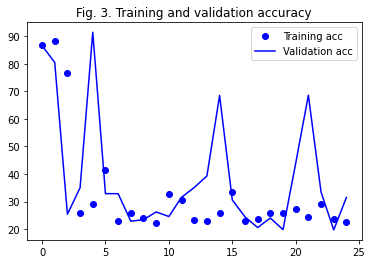

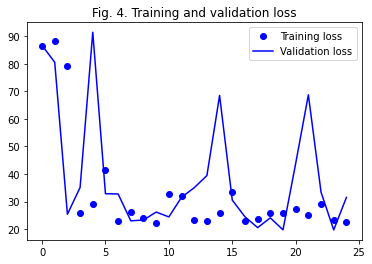

In [ ]:
# plotting the model history 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Fig. 3. Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Fig. 4. Training and validation loss')
plt.legend()

plt.show()

### 3.0 EfficentNet model

In [ ]:
inputs = layers.Input(
        shape=(224, 224, 3)
    )  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    # utilising the EfficiientNetB0 weight previously downloaded
model_2 = EfficientNetB0(include_top=False, input_tensor=inputs, weights="efficientnetb0_notop.h5")
    # Freeze the pretrained weights
model_2.trainable = False

    # Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model_2.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, name="pred")(x)

    # Compile
model_2 = keras.Model(inputs, outputs, name="EfficientNet")

In [ ]:
# absolute mean error optimizer

radam2 = tfa.optimizers.RectifiedAdam(learning_rate=ef_net_lr)
ranger2 = tfa.optimizers.Lookahead(radam2, sync_period=6, slow_step_size=0.5)
optimizer2 = ranger2

In [ ]:
model_2.compile(optimizer=optimizer2, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )

In [ ]:
# running the EfficentNet model 

history_eff_net = model_2.fit( train_generator, 
                     epochs = 25,
                     steps_per_epoch = 2,
                     validation_data=validation_generator,
                     workers = 6,)

Epoch 1/25
2/2 [==============================] - 92s 17s/step - loss: 83.2862 - mean_absolute_error: 82.8039 - mean_absolute_percentage_error: 99.1227 - val_loss: 79.2886 - val_mean_absolute_error: 79.5290 - val_mean_absolute_percentage_error: 94.6998
Epoch 2/25
2/2 [==============================] - 36s 14s/step - loss: 76.2659 - mean_absolute_error: 76.2659 - mean_absolute_percentage_error: 92.0890 - val_loss: 69.1057 - val_mean_absolute_error: 69.4074 - val_mean_absolute_percentage_error: 81.2335
Epoch 3/25
2/2 [==============================] - 34s 13s/step - loss: 67.8187 - mean_absolute_error: 66.2443 - mean_absolute_percentage_error: 75.1064 - val_loss: 74.0783 - val_mean_absolute_error: 74.0424 - val_mean_absolute_percentage_error: 87.7663
Epoch 4/25
2/2 [==============================] - 34s 19s/step - loss: 73.2941 - mean_absolute_error: 74.2784 - mean_absolute_percentage_error: 85.8573 - val_loss: 68.0138 - val_mean_absolute_error: 67.8886 - val_mean_absolute_percentage_err

In [ ]:
# plotting the model 
acc = history_eff_net.history['mean_absolute_error']
val_acc = history_eff_net.history['val_mean_absolute_error']
loss = history_eff_net.history['loss']
val_loss = history_eff_net.history['val_loss']

epochs = range(len(acc))

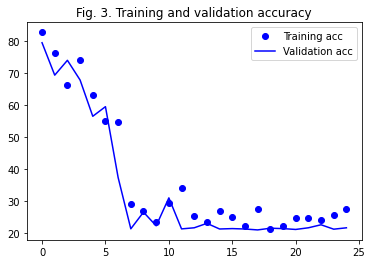

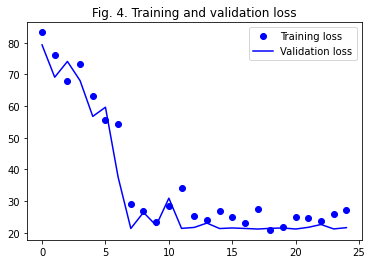

In [ ]:
# Plotting the tranining and validation accuracy 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Fig. 3. Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting the training and validation loss

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Fig. 4. Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#history_eff_net.history


Saving the results from the model training in a pickle file to compare to history results from other models. 

### 4.0 Visualizing Layers

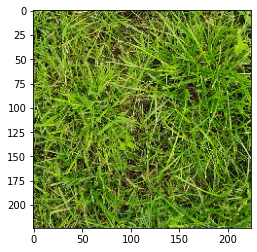

Compressed Sward Height Measurement: 73mm
Estimated Compressed Sward Height: [[116.45934]]mm


In [ ]:
# Loading a sample image from the data set to convert to a tensor and resize to an acceptable shape.
img_path = './images/567.png'

img = image.load_img(img_path, target_size=(224,224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor/=255

plt.imshow(img_tensor[0])

# The image plotted below
plt.show()



print('Compressed Sward Height Measurement: ' + str(df.loc[567,'label']) + 'mm')

print( 'Estimated Compressed Sward Height: ' + str(model.predict(img_tensor)) + 'mm')

In [ ]:
# visualizing the activations 
layers_output = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs=model.input, outputs=layers_output)


activations = activation_model.predict(img_tensor)

a_layer_activation = activations[0]
b_layer_activation = activations[1]
c_layer_activation = activations[2]
d_layer_activation = activations[3]
e_layer_activation = activations[4]
f_layer_activation = activations[5]

print(a_layer_activation.shape)

(1, 222, 222, 32)


Text(0.5, 1.0, '4th Layer')

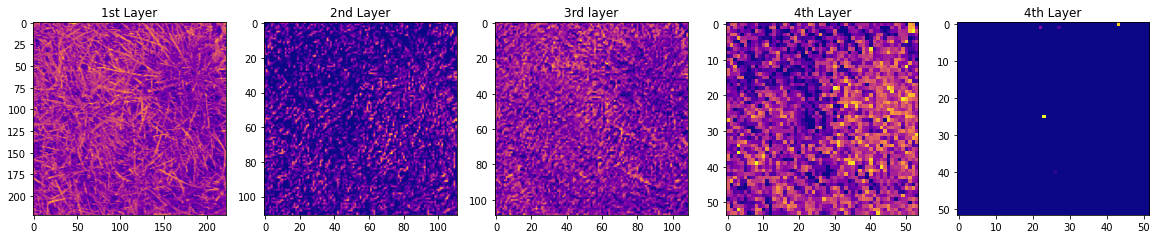

In [ ]:
#Plotted below is the output of 5 channels in the first layer 
f, axarr =  plt.subplots(1,5, figsize=(20, 15))

axarr[0].imshow(a_layer_activation[0, :, :, 1], cmap='plasma')
axarr[0].set_title('1st Layer')

axarr[1].imshow(b_layer_activation[0, :, :, 2], cmap='plasma')
axarr[1].set_title('2nd Layer')

axarr[2].imshow(c_layer_activation[0, :, :, 15], cmap='plasma')
axarr[2].set_title('3rd layer')

axarr[3].imshow(d_layer_activation[0, :, :, 4], cmap='plasma')
axarr[3].set_title('4th Layer')

axarr[4].imshow(e_layer_activation[0, :, :, 4], cmap='plasma')
axarr[4].set_title('4th Layer')

### 5.0 Predictions

In [ ]:
# runnning all the images through the model to collect predictions

predict_datagen = ImageDataGenerator(rescale=1.0 / 255,   # final image size of 255 * 255
       )


predict_generator = predict_datagen.flow_from_dataframe(
        # This is the target directory
        dataframe=df,
        x_col="image_location",  # locates folder where images are stored
        y_col="label",
        target_size=(224, 224),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need classification labels
        class_mode='raw', 
        shuffle = False)

Found 601 validated image filenames.


In [ ]:
small_cnn_results = (model.predict(predict_generator))
small_cnn_results = [i[0] for i in small_cnn_results]
df['small_cnn'] = small_cnn_results

In [ ]:
eff_net_results = (model_2.predict(predict_generator))
eff_net_results = [i[0] for i in eff_net_results]
df['eff_net'] = eff_net_results

### 6.0 Vegetation Indicies

In [ ]:
# 
images = os.listdir('./images')
num_images = len(images)

In [ ]:
# filtering out the red and blue channels to calculate the mean green value of the pixels in an image
green_data = []

for i in range(num_images):
    image = cv.imread('./images/' + images[i] )
    b, g, r    = image[:, :, 0], image[:, :, 1], image[:, :, 2] # matching the red, green and blue pixel values 
   

    res = np.mean(g) # calculate mean of the green values in an image
    res = round(res, 2)

    green_data.append([res]) 

In [ ]:
# the visable normalised difference vegetation index
ndvi_data = []

for i in range(num_images):
    image = cv.imread('./images/' + images[i] )
    b, g, r    = image[:, :, 0], image[:, :, 1], image[:, :, 2] 
    r[r==0] = 1 
    b[b==0] = 1 

    vi = 0.5268 * (pow(r, -0.1294) * pow(g, 0.3389) * pow(b, -0.3118)) # the vNDVI transformation 
    res = np.mean(vi) # calculating the mean value of each pixel in the image
    res100 = res * 100
    mean = round(res100, 2)

    ndvi_data.append([mean]) 
    

In [ ]:
# adding the vegetation index transformations to the data frame to save later
green_data = [i[0] for i in green_data] # values from the green channel
df['green'] = green_data

ndvi_data = [i[0] for i in ndvi_data] # values from the vNDVI transformation
df['vndvi'] = ndvi_data

### 7.0 Saving Results 

In [ ]:
# saving the small_cnn history as a pickle file
with open('small_cnn_history.pickle', 'wb') as f:
    pickle.dump(history_small_cnn.history, f)

# saving the EfficentNet history as a pickle
with open('eff_net_history.pickle', 'wb') as f:
    pickle.dump(history_eff_net.history, f)

# opening the pickle file
#with open('small_cnn_rmse.pickle', 'rb') as f:
#    cn1 = pickle.load(f)

In [ ]:
# Including the data dictionary in the .xlsx file
data_dictionary = (
    ['image_name', 'name of each image minus the .png extension'],
    ['label',   'the recorded compressed sward height measurement for the corresponding image'],
    ['image_location',  'the loaction of the file within the working directory'],
    ['small_cnn', 'the estimated compressed sward height from the Small CNN model'],
    ['eff_net', 'the estimated compressed sward height from the EfficientNet model'], 
    ['green', 'the mean value of the green channel within each pixel of an imagee'], 
    ['vndvi', 'the transformation of the visable normalised difference transformation index']
)

dd = pd.DataFrame(data_dictionary)

In [ ]:
# writing the excel file to the results folder
writer = pd.ExcelWriter('./results/predictions.xlsx', engine = 'xlsxwriter')

df.to_excel(writer, sheet_name = 'Sheet 1', index = False)
dd.to_excel(writer, sheet_name = 'data_dictionary', index = False)

writer.save()